![](../img/banner_day2.png)

<br>

# 3일차 실습(3) - 합성곱 신경망(CNN)

<br>
<br>
<div align='right'>강사 성민석</div>
<div align='right'>고려대학교 인공지능학과 박사과정</div>
<div align='right'>(minsuksung@korea.ac.kr)</div>

> <font color='red'><b>WARNING</b></font>: 본 컨텐츠는 **[저작권법 제25조 제2항](https://glaw.scourt.go.kr/wsjo/lawod/sjo192.do?contId=2135829&jomunNo=25)** 에 의해 강의 목적으로 이용한 저작물이 포함되어 있습니다.  
> 해당 자료를 제작자의 동의없이 <font color='red'><b>외부에 임의로 공개 및 수정하는 것을 금지</b></font>하며 이를 위반하는 경우 저작권 침해로서 관련법에 따라 처벌될 수 있으니 주의해주시기 바랍니다.

<h1>목차<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터셋과-데이터로더-생성하기" data-toc-modified-id="데이터셋과-데이터로더-생성하기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터셋과 데이터로더 생성하기</a></span></li><li><span><a href="#신경망-모델-구성하기" data-toc-modified-id="신경망-모델-구성하기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>신경망 모델 구성하기</a></span></li><li><span><a href="#손실-함수-및-최적화-방법-설정하기" data-toc-modified-id="손실-함수-및-최적화-방법-설정하기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>손실 함수 및 최적화 방법 설정하기</a></span></li><li><span><a href="#신경망-학습-및-평가하기" data-toc-modified-id="신경망-학습-및-평가하기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>신경망 학습 및 평가하기</a></span></li><li><span><a href="#참고자료" data-toc-modified-id="참고자료-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>참고자료</a></span></li></ul></div>

![](../img/pipeline2.png)

In [1]:
import os
import sys
import gzip
import random
import platform
import warnings
import collections
from tqdm import tqdm, tqdm_notebook

In [2]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
# Set random seed
SEED = 2022
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [5]:
# 현재 OS 및 라이브러리 버전 체크 체크
current_os = platform.system()
print(f"Current OS: {current_os}")
print(f"CUDA: {torch.cuda.is_available()}")
print(f"Python Version: {platform.python_version()}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")

# 중요하지 않은 에러 무시
warnings.filterwarnings(action='ignore')

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

Current OS: Linux
CUDA: True
Python Version: 3.7.10
torch Version: 1.8.2+cu111
torchvision Version: 0.9.2+cu111


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 데이터셋과 데이터로더 생성하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [139]:
dataset_train_MNIST = torchvision.datasets.MNIST(
    '../data/MNIST/',  # 다운로드 경로 지정
    train=True,  # True를 지정하면 훈련 데이터로 다운로드
    transform=transforms.ToTensor(),  # 텐서로 변환
    download=True,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw

Processing...
Done!


In [140]:
dataset_test_MNIST = torchvision.datasets.MNIST(
    '../data/MNIST/',  # 다운로드 경로 지정
    train=False,  # True를 지정하면 훈련 데이터로 다운로드
    transform=transforms.ToTensor(),  # 텐서로 변환
    download=True,
)

In [141]:
dataset_train_MNIST

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [142]:
dataset_test_MNIST

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/MNIST/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [143]:
len(dataset_train_MNIST), len(dataset_test_MNIST)

(60000, 10000)

In [10]:
dataset_train_MNIST.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [11]:
image, label = next(iter(dataset_train_MNIST))
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
image.shape

torch.Size([1, 28, 28])

In [13]:
pd.DataFrame(np.int32(image.numpy()[0]*255)).style.set_properties(**{'font-size':'3pt'}).background_gradient(axis=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


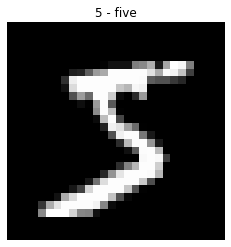

In [14]:
plt.imshow(image.numpy().squeeze(), cmap='gray')
plt.title("{}".format(dataset_train_MNIST.classes[label]))
plt.axis('off')
plt.show()

In [186]:
batch_size = 16

In [187]:
dataloader_train_MNIST = DataLoader(
    dataset=dataset_train_MNIST,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

In [188]:
dataloader_test_MNIST = DataLoader(
    dataset=dataset_test_MNIST,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

In [189]:
images, labels = next(iter(dataloader_train_MNIST))

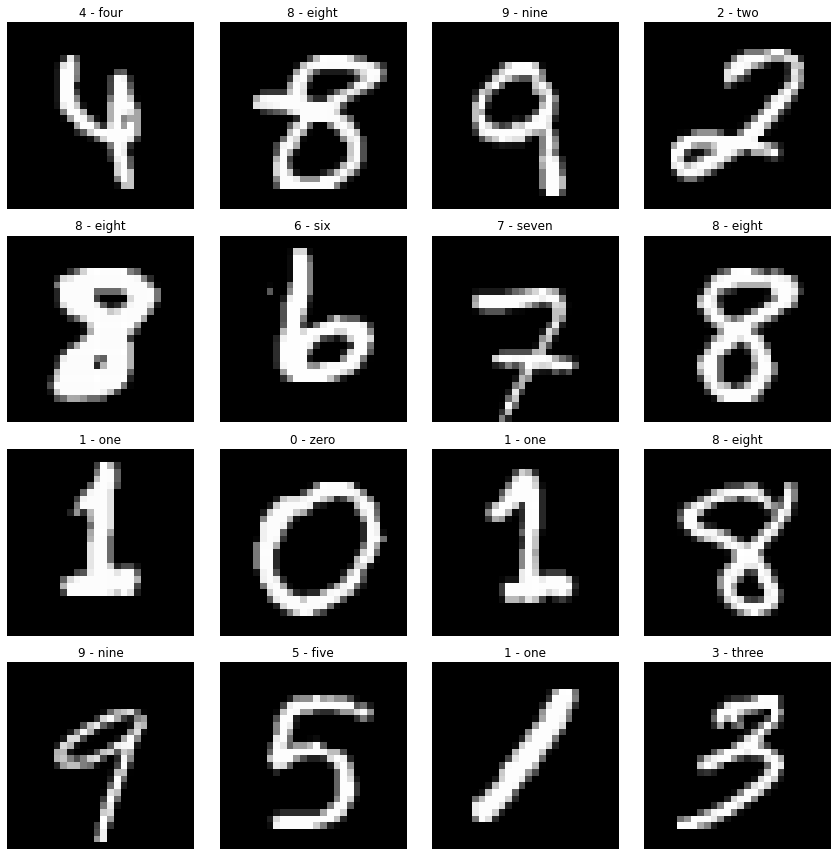

In [190]:
plt.figure(figsize=(12,12))
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title("{}".format(dataset_train_MNIST.classes[label]))
    plt.axis('off')
plt.tight_layout()
plt.show() 

## 신경망 모델 구성하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [358]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # Conv + Pooling
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        
        # Conv + Pooling
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        # Conv + Pooling
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        
        # FC layer
        x = x.view(-1, 32*1*1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x)
        
        return x

In [359]:
model = CNN().to(device)
output = model(torch.randn(1, 1, 28, 28).to(device))  # 테스트
output

tensor([[0.1020, 0.0805, 0.0905, 0.0883, 0.0831, 0.1088, 0.0965, 0.1033, 0.1237,
         0.1232]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [360]:
# 전체 학습 파라미터 확인
total_params = sum(p.numel() for p in model.parameters())
print("Num of Parameters : ",total_params)

Num of Parameters :  7274


## 손실 함수 및 최적화 방법 설정하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

In [361]:
loss_fn = nn.CrossEntropyLoss().to(device) # 손실함수 설정하기
loss_fn

CrossEntropyLoss()

In [362]:
optimizer = optim.Adam(model.parameters(),lr=1e-4) # 옵티마이저 설정하기
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

## 신경망 학습 및 평가하기
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

[2022-08-30 19:23:12.779655 - TRAIN] Epoch  1 / 10 Batch:  100 / 3750 Loss:   2.30 Acc:  8.62% (   138 /  1,600)
[2022-08-30 19:23:13.301893 - TRAIN] Epoch  1 / 10 Batch:  200 / 3750 Loss:   2.31 Acc: 10.53% (   337 /  3,200)
[2022-08-30 19:23:13.810668 - TRAIN] Epoch  1 / 10 Batch:  300 / 3750 Loss:   2.30 Acc: 11.44% (   549 /  4,800)
[2022-08-30 19:23:14.344663 - TRAIN] Epoch  1 / 10 Batch:  400 / 3750 Loss:   2.30 Acc: 12.56% (   804 /  6,400)
[2022-08-30 19:23:14.877701 - TRAIN] Epoch  1 / 10 Batch:  500 / 3750 Loss:   2.29 Acc: 12.99% ( 1,039 /  8,000)
[2022-08-30 19:23:15.425179 - TRAIN] Epoch  1 / 10 Batch:  600 / 3750 Loss:   2.29 Acc: 13.51% ( 1,297 /  9,600)
[2022-08-30 19:23:15.972349 - TRAIN] Epoch  1 / 10 Batch:  700 / 3750 Loss:   2.22 Acc: 14.78% ( 1,655 / 11,200)
[2022-08-30 19:23:16.524873 - TRAIN] Epoch  1 / 10 Batch:  800 / 3750 Loss:   2.19 Acc: 16.84% ( 2,155 / 12,800)
[2022-08-30 19:23:17.096633 - TRAIN] Epoch  1 / 10 Batch:  900 / 3750 Loss:   2.14 Acc: 19.16% (

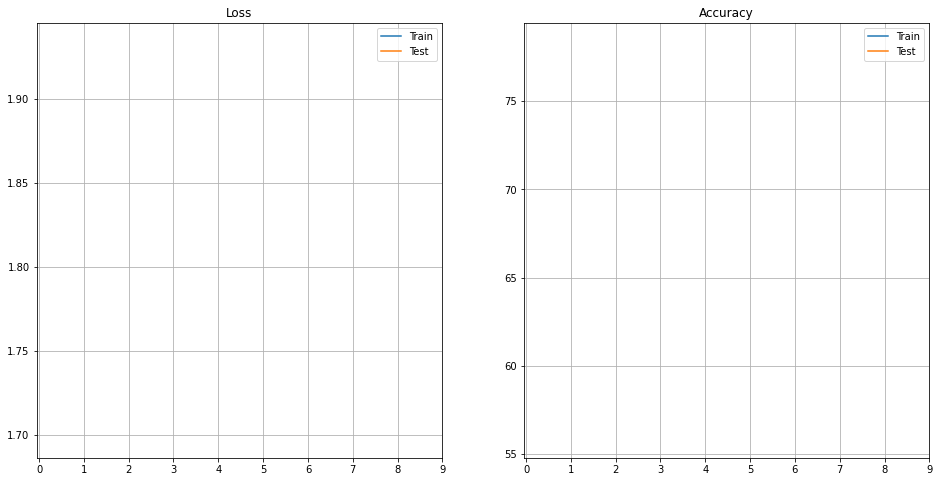

[2022-08-30 19:23:38.098355 - TRAIN] Epoch  2 / 10 Batch:  100 / 3750 Loss:   1.83 Acc: 78.25% ( 1,252 /  1,600)
[2022-08-30 19:23:38.757895 - TRAIN] Epoch  2 / 10 Batch:  200 / 3750 Loss:   1.73 Acc: 77.81% ( 2,490 /  3,200)
[2022-08-30 19:23:39.421174 - TRAIN] Epoch  2 / 10 Batch:  300 / 3750 Loss:   1.70 Acc: 77.35% ( 3,713 /  4,800)
[2022-08-30 19:23:40.071569 - TRAIN] Epoch  2 / 10 Batch:  400 / 3750 Loss:   1.56 Acc: 77.70% ( 4,973 /  6,400)
[2022-08-30 19:23:40.640172 - TRAIN] Epoch  2 / 10 Batch:  500 / 3750 Loss:   1.81 Acc: 77.75% ( 6,220 /  8,000)
[2022-08-30 19:23:41.068431 - TRAIN] Epoch  2 / 10 Batch:  600 / 3750 Loss:   1.72 Acc: 77.83% ( 7,472 /  9,600)
[2022-08-30 19:23:41.483940 - TRAIN] Epoch  2 / 10 Batch:  700 / 3750 Loss:   1.64 Acc: 77.85% ( 8,719 / 11,200)
[2022-08-30 19:23:41.896130 - TRAIN] Epoch  2 / 10 Batch:  800 / 3750 Loss:   1.57 Acc: 77.79% ( 9,957 / 12,800)
[2022-08-30 19:23:42.309799 - TRAIN] Epoch  2 / 10 Batch:  900 / 3750 Loss:   1.62 Acc: 77.92% (

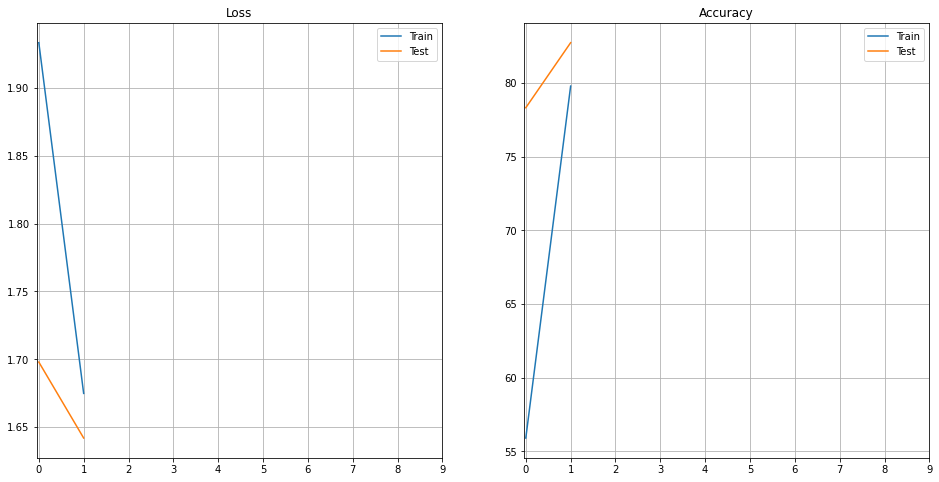

[2022-08-30 19:24:00.937838 - TRAIN] Epoch  3 / 10 Batch:  100 / 3750 Loss:   1.67 Acc: 83.75% ( 1,340 /  1,600)
[2022-08-30 19:24:01.576111 - TRAIN] Epoch  3 / 10 Batch:  200 / 3750 Loss:   1.71 Acc: 83.41% ( 2,669 /  3,200)
[2022-08-30 19:24:02.217837 - TRAIN] Epoch  3 / 10 Batch:  300 / 3750 Loss:   1.53 Acc: 83.19% ( 3,993 /  4,800)
[2022-08-30 19:24:02.860762 - TRAIN] Epoch  3 / 10 Batch:  400 / 3750 Loss:   1.64 Acc: 82.58% ( 5,285 /  6,400)
[2022-08-30 19:24:03.505758 - TRAIN] Epoch  3 / 10 Batch:  500 / 3750 Loss:   1.65 Acc: 82.47% ( 6,598 /  8,000)
[2022-08-30 19:24:04.152219 - TRAIN] Epoch  3 / 10 Batch:  600 / 3750 Loss:   1.64 Acc: 82.43% ( 7,913 /  9,600)
[2022-08-30 19:24:04.802308 - TRAIN] Epoch  3 / 10 Batch:  700 / 3750 Loss:   1.58 Acc: 82.62% ( 9,253 / 11,200)
[2022-08-30 19:24:05.455753 - TRAIN] Epoch  3 / 10 Batch:  800 / 3750 Loss:   1.53 Acc: 82.58% (10,570 / 12,800)
[2022-08-30 19:24:06.107904 - TRAIN] Epoch  3 / 10 Batch:  900 / 3750 Loss:   1.68 Acc: 82.57% (

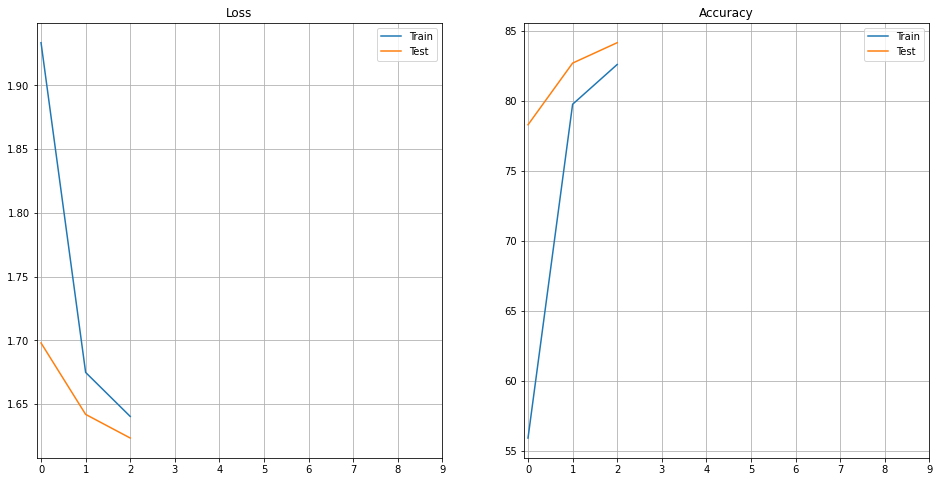

[2022-08-30 19:24:27.024150 - TRAIN] Epoch  4 / 10 Batch:  100 / 3750 Loss:   1.69 Acc: 85.00% ( 1,360 /  1,600)
[2022-08-30 19:24:27.662989 - TRAIN] Epoch  4 / 10 Batch:  200 / 3750 Loss:   1.83 Acc: 84.38% ( 2,700 /  3,200)
[2022-08-30 19:24:28.310471 - TRAIN] Epoch  4 / 10 Batch:  300 / 3750 Loss:   1.83 Acc: 84.31% ( 4,047 /  4,800)
[2022-08-30 19:24:28.962093 - TRAIN] Epoch  4 / 10 Batch:  400 / 3750 Loss:   1.67 Acc: 84.39% ( 5,401 /  6,400)
[2022-08-30 19:24:29.611296 - TRAIN] Epoch  4 / 10 Batch:  500 / 3750 Loss:   1.65 Acc: 84.09% ( 6,727 /  8,000)
[2022-08-30 19:24:30.252924 - TRAIN] Epoch  4 / 10 Batch:  600 / 3750 Loss:   1.60 Acc: 84.04% ( 8,068 /  9,600)
[2022-08-30 19:24:30.891288 - TRAIN] Epoch  4 / 10 Batch:  700 / 3750 Loss:   1.52 Acc: 83.86% ( 9,392 / 11,200)
[2022-08-30 19:24:31.529539 - TRAIN] Epoch  4 / 10 Batch:  800 / 3750 Loss:   1.76 Acc: 83.71% (10,715 / 12,800)
[2022-08-30 19:24:32.188399 - TRAIN] Epoch  4 / 10 Batch:  900 / 3750 Loss:   1.53 Acc: 83.72% (

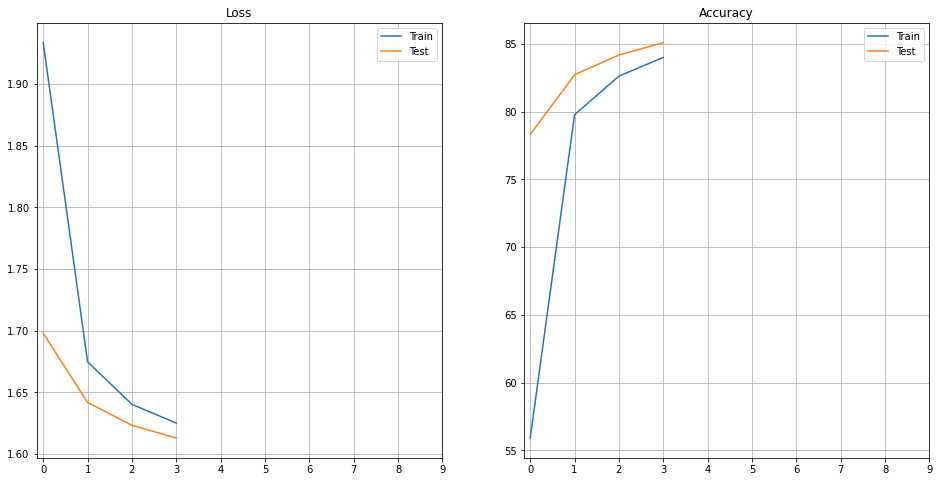

[2022-08-30 19:24:54.214893 - TRAIN] Epoch  5 / 10 Batch:  100 / 3750 Loss:   1.59 Acc: 85.31% ( 1,365 /  1,600)
[2022-08-30 19:24:54.818855 - TRAIN] Epoch  5 / 10 Batch:  200 / 3750 Loss:   1.59 Acc: 84.75% ( 2,712 /  3,200)
[2022-08-30 19:24:55.432461 - TRAIN] Epoch  5 / 10 Batch:  300 / 3750 Loss:   1.59 Acc: 84.50% ( 4,056 /  4,800)
[2022-08-30 19:24:56.052572 - TRAIN] Epoch  5 / 10 Batch:  400 / 3750 Loss:   1.63 Acc: 84.31% ( 5,396 /  6,400)
[2022-08-30 19:24:56.681537 - TRAIN] Epoch  5 / 10 Batch:  500 / 3750 Loss:   1.54 Acc: 84.52% ( 6,762 /  8,000)
[2022-08-30 19:24:57.301502 - TRAIN] Epoch  5 / 10 Batch:  600 / 3750 Loss:   1.65 Acc: 84.38% ( 8,100 /  9,600)
[2022-08-30 19:24:57.926351 - TRAIN] Epoch  5 / 10 Batch:  700 / 3750 Loss:   1.81 Acc: 84.46% ( 9,459 / 11,200)
[2022-08-30 19:24:58.553958 - TRAIN] Epoch  5 / 10 Batch:  800 / 3750 Loss:   1.56 Acc: 84.44% (10,808 / 12,800)
[2022-08-30 19:24:59.177578 - TRAIN] Epoch  5 / 10 Batch:  900 / 3750 Loss:   1.53 Acc: 84.53% (

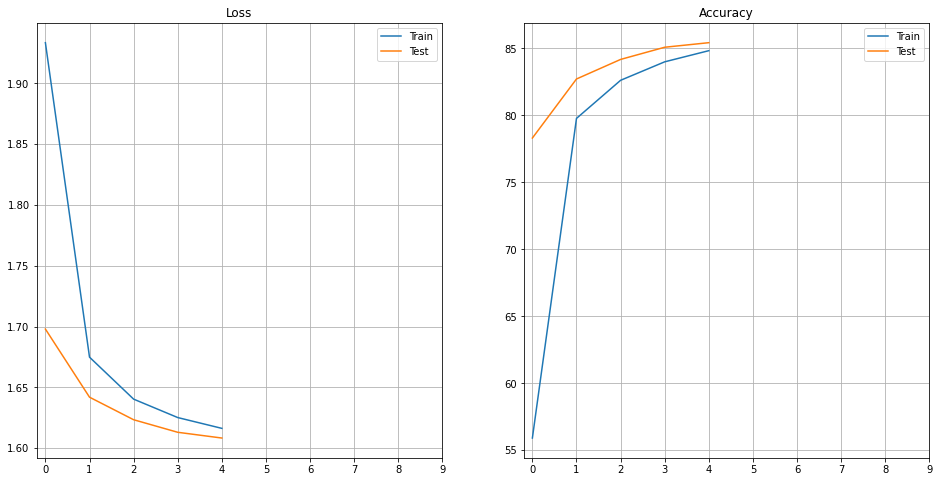

[2022-08-30 19:25:21.083882 - TRAIN] Epoch  6 / 10 Batch:  100 / 3750 Loss:   1.65 Acc: 86.25% ( 1,380 /  1,600)
[2022-08-30 19:25:21.694000 - TRAIN] Epoch  6 / 10 Batch:  200 / 3750 Loss:   1.48 Acc: 85.12% ( 2,724 /  3,200)
[2022-08-30 19:25:22.311462 - TRAIN] Epoch  6 / 10 Batch:  300 / 3750 Loss:   1.70 Acc: 84.96% ( 4,078 /  4,800)
[2022-08-30 19:25:22.927723 - TRAIN] Epoch  6 / 10 Batch:  400 / 3750 Loss:   1.52 Acc: 85.47% ( 5,470 /  6,400)
[2022-08-30 19:25:23.563529 - TRAIN] Epoch  6 / 10 Batch:  500 / 3750 Loss:   1.65 Acc: 85.34% ( 6,827 /  8,000)
[2022-08-30 19:25:24.204082 - TRAIN] Epoch  6 / 10 Batch:  600 / 3750 Loss:   1.61 Acc: 85.41% ( 8,199 /  9,600)
[2022-08-30 19:25:24.847013 - TRAIN] Epoch  6 / 10 Batch:  700 / 3750 Loss:   1.65 Acc: 85.62% ( 9,589 / 11,200)
[2022-08-30 19:25:25.487901 - TRAIN] Epoch  6 / 10 Batch:  800 / 3750 Loss:   1.70 Acc: 85.55% (10,950 / 12,800)
[2022-08-30 19:25:26.131916 - TRAIN] Epoch  6 / 10 Batch:  900 / 3750 Loss:   1.68 Acc: 85.47% (

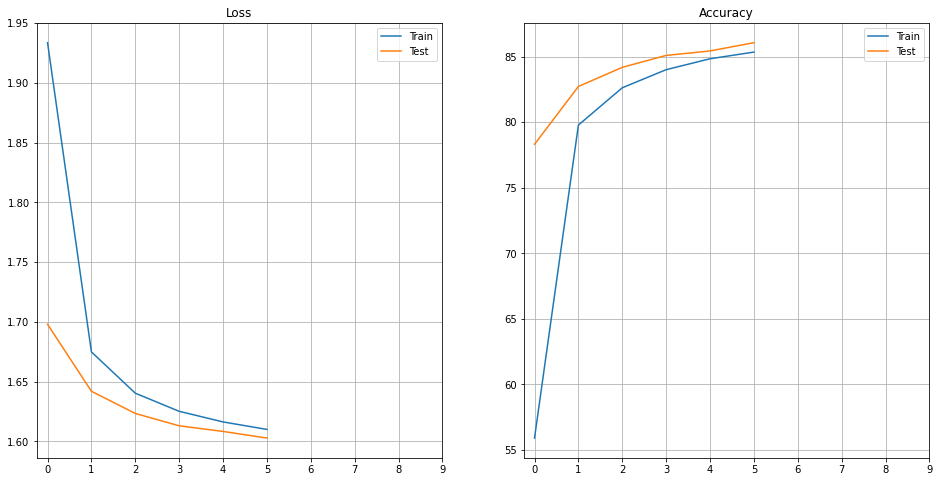

[2022-08-30 19:25:46.751913 - TRAIN] Epoch  7 / 10 Batch:  100 / 3750 Loss:   1.84 Acc: 84.88% ( 1,358 /  1,600)
[2022-08-30 19:25:47.409131 - TRAIN] Epoch  7 / 10 Batch:  200 / 3750 Loss:   1.55 Acc: 85.12% ( 2,724 /  3,200)
[2022-08-30 19:25:48.052376 - TRAIN] Epoch  7 / 10 Batch:  300 / 3750 Loss:   1.59 Acc: 85.08% ( 4,084 /  4,800)
[2022-08-30 19:25:48.698410 - TRAIN] Epoch  7 / 10 Batch:  400 / 3750 Loss:   1.65 Acc: 85.25% ( 5,456 /  6,400)
[2022-08-30 19:25:49.346458 - TRAIN] Epoch  7 / 10 Batch:  500 / 3750 Loss:   1.61 Acc: 85.40% ( 6,832 /  8,000)
[2022-08-30 19:25:49.992020 - TRAIN] Epoch  7 / 10 Batch:  600 / 3750 Loss:   1.59 Acc: 85.47% ( 8,205 /  9,600)
[2022-08-30 19:25:50.639926 - TRAIN] Epoch  7 / 10 Batch:  700 / 3750 Loss:   1.59 Acc: 85.47% ( 9,573 / 11,200)
[2022-08-30 19:25:51.286437 - TRAIN] Epoch  7 / 10 Batch:  800 / 3750 Loss:   1.65 Acc: 85.62% (10,960 / 12,800)
[2022-08-30 19:25:51.931771 - TRAIN] Epoch  7 / 10 Batch:  900 / 3750 Loss:   1.52 Acc: 85.76% (

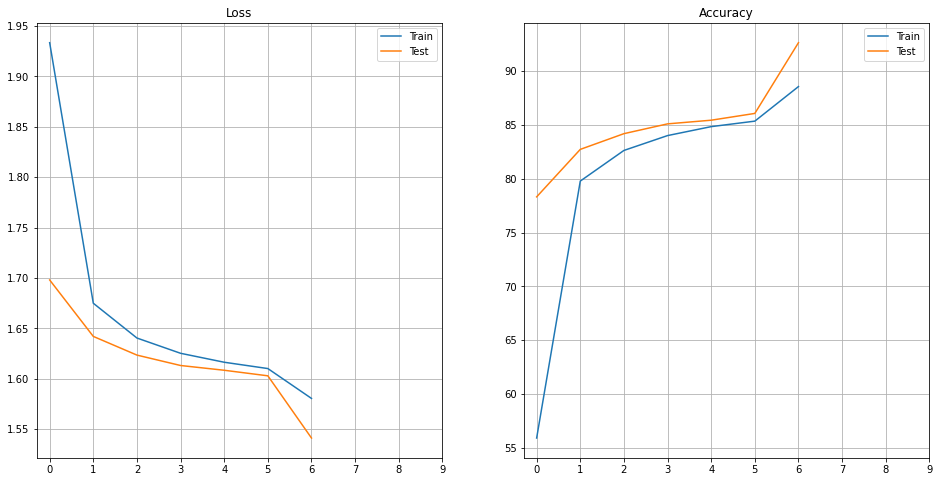

[2022-08-30 19:26:12.539073 - TRAIN] Epoch  8 / 10 Batch:  100 / 3750 Loss:   1.48 Acc: 92.44% ( 1,479 /  1,600)
[2022-08-30 19:26:13.183561 - TRAIN] Epoch  8 / 10 Batch:  200 / 3750 Loss:   1.53 Acc: 92.78% ( 2,969 /  3,200)
[2022-08-30 19:26:13.842565 - TRAIN] Epoch  8 / 10 Batch:  300 / 3750 Loss:   1.52 Acc: 92.10% ( 4,421 /  4,800)
[2022-08-30 19:26:14.502031 - TRAIN] Epoch  8 / 10 Batch:  400 / 3750 Loss:   1.51 Acc: 92.16% ( 5,898 /  6,400)
[2022-08-30 19:26:15.132825 - TRAIN] Epoch  8 / 10 Batch:  500 / 3750 Loss:   1.58 Acc: 92.24% ( 7,379 /  8,000)
[2022-08-30 19:26:15.768538 - TRAIN] Epoch  8 / 10 Batch:  600 / 3750 Loss:   1.52 Acc: 92.09% ( 8,841 /  9,600)
[2022-08-30 19:26:16.447579 - TRAIN] Epoch  8 / 10 Batch:  700 / 3750 Loss:   1.46 Acc: 92.28% (10,335 / 11,200)
[2022-08-30 19:26:17.127153 - TRAIN] Epoch  8 / 10 Batch:  800 / 3750 Loss:   1.70 Acc: 92.40% (11,827 / 12,800)
[2022-08-30 19:26:17.794508 - TRAIN] Epoch  8 / 10 Batch:  900 / 3750 Loss:   1.61 Acc: 92.39% (

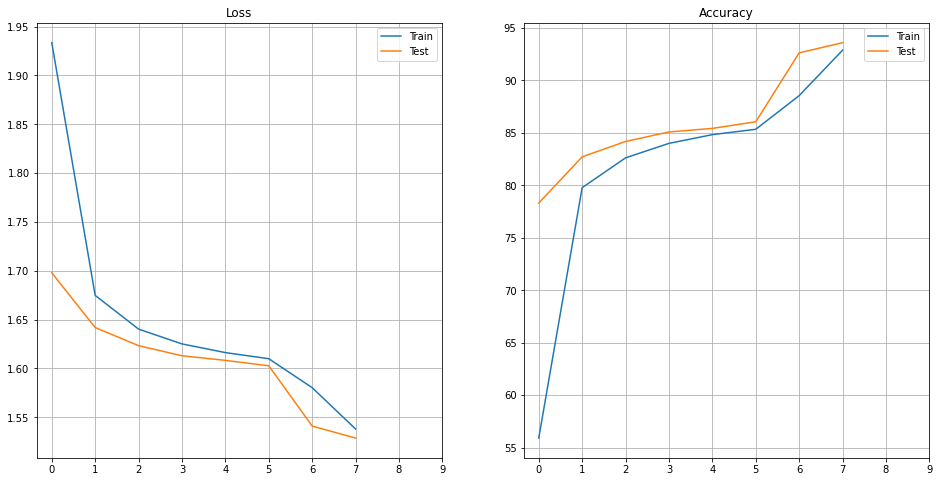

[2022-08-30 19:26:39.787242 - TRAIN] Epoch  9 / 10 Batch:  100 / 3750 Loss:   1.49 Acc: 93.75% ( 1,500 /  1,600)
[2022-08-30 19:26:40.425356 - TRAIN] Epoch  9 / 10 Batch:  200 / 3750 Loss:   1.51 Acc: 93.72% ( 2,999 /  3,200)
[2022-08-30 19:26:41.059821 - TRAIN] Epoch  9 / 10 Batch:  300 / 3750 Loss:   1.46 Acc: 93.69% ( 4,497 /  4,800)
[2022-08-30 19:26:41.704653 - TRAIN] Epoch  9 / 10 Batch:  400 / 3750 Loss:   1.51 Acc: 93.50% ( 5,984 /  6,400)
[2022-08-30 19:26:42.214976 - TRAIN] Epoch  9 / 10 Batch:  500 / 3750 Loss:   1.51 Acc: 93.66% ( 7,493 /  8,000)
[2022-08-30 19:26:42.644571 - TRAIN] Epoch  9 / 10 Batch:  600 / 3750 Loss:   1.48 Acc: 93.69% ( 8,994 /  9,600)
[2022-08-30 19:26:43.073821 - TRAIN] Epoch  9 / 10 Batch:  700 / 3750 Loss:   1.52 Acc: 93.65% (10,489 / 11,200)
[2022-08-30 19:26:43.506420 - TRAIN] Epoch  9 / 10 Batch:  800 / 3750 Loss:   1.47 Acc: 93.63% (11,985 / 12,800)
[2022-08-30 19:26:43.943655 - TRAIN] Epoch  9 / 10 Batch:  900 / 3750 Loss:   1.48 Acc: 93.62% (

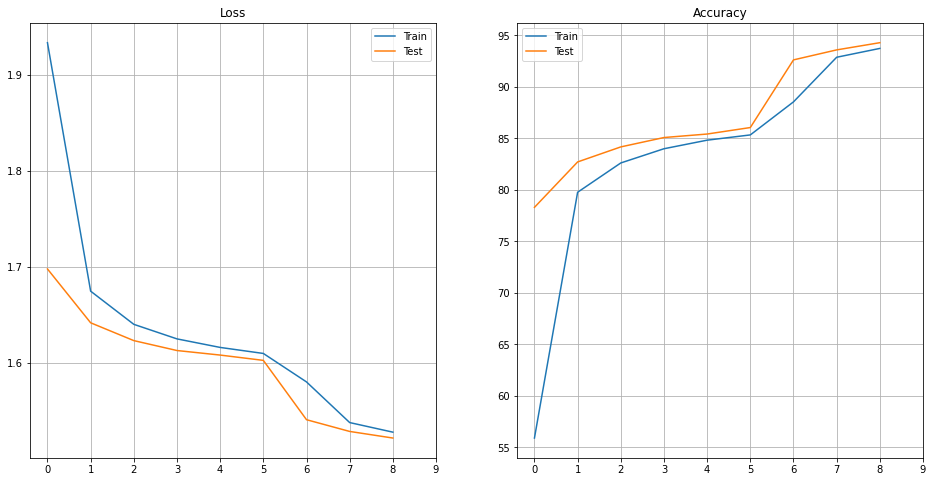

[2022-08-30 19:27:01.196087 - TRAIN] Epoch 10 / 10 Batch:  100 / 3750 Loss:   1.58 Acc: 93.50% ( 1,496 /  1,600)
[2022-08-30 19:27:01.811632 - TRAIN] Epoch 10 / 10 Batch:  200 / 3750 Loss:   1.47 Acc: 93.50% ( 2,992 /  3,200)
[2022-08-30 19:27:02.441640 - TRAIN] Epoch 10 / 10 Batch:  300 / 3750 Loss:   1.51 Acc: 93.52% ( 4,489 /  4,800)
[2022-08-30 19:27:03.073195 - TRAIN] Epoch 10 / 10 Batch:  400 / 3750 Loss:   1.49 Acc: 93.75% ( 6,000 /  6,400)
[2022-08-30 19:27:03.707268 - TRAIN] Epoch 10 / 10 Batch:  500 / 3750 Loss:   1.53 Acc: 93.85% ( 7,508 /  8,000)
[2022-08-30 19:27:04.338209 - TRAIN] Epoch 10 / 10 Batch:  600 / 3750 Loss:   1.46 Acc: 93.86% ( 9,011 /  9,600)
[2022-08-30 19:27:04.969794 - TRAIN] Epoch 10 / 10 Batch:  700 / 3750 Loss:   1.49 Acc: 93.96% (10,524 / 11,200)
[2022-08-30 19:27:05.598781 - TRAIN] Epoch 10 / 10 Batch:  800 / 3750 Loss:   1.53 Acc: 93.97% (12,028 / 12,800)
[2022-08-30 19:27:06.227096 - TRAIN] Epoch 10 / 10 Batch:  900 / 3750 Loss:   1.51 Acc: 93.99% (

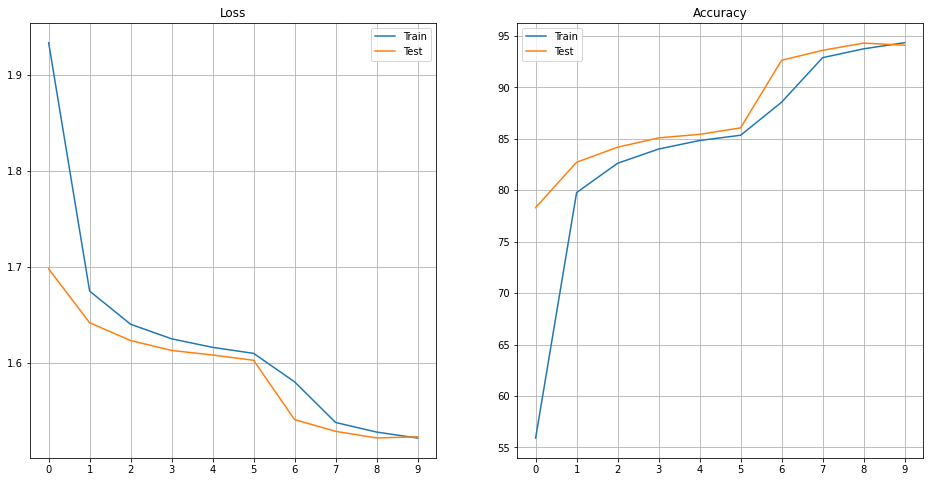

In [363]:
import datetime

epochs = 10

loss_train = []
acc_train = []
loss_test = []
acc_test = []

for i in range(epochs):
    ##################################################################################################################
    #                                                        학습                                                    #
    ##################################################################################################################
    model.train()
    correct_train = 0
    losses = []

    for batch_idx, (batch_X, batch_y) in enumerate(dataloader_train_MNIST, start=1):

        # 데이터를 모두 GPU로
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # 학습할 때는 매번 그래디언트를 0으로 초기화
        optimizer.zero_grad()

        # 모델 입력
        output = model(batch_X)

        # 오차 계산하기
        loss = loss_fn(output, batch_y)

        # 오차를 역전파하여 계산함
        loss.backward()
        losses.append(loss.item())

        # 역전파 계산한 값으로 가중치를 수정
        optimizer.step()

        # 정확도 계산
        pred = output.argmax(dim=1, keepdim=True)
        correct_train += pred.eq(batch_y.view_as(pred)).sum().item()
        acc = correct_train / (batch_idx*batch_size) * 100

        if batch_idx % 100 == 0:
            print('\033[32m[{} - {}]\033[0m '
                  'Epoch {:>2d} / {:>2d} '
                  'Batch: {:>4d} / {:>4d} '
                  'Loss: {:>6.2f} '
                  'Acc: {:5.2f}% ({:6,} / {:6,})'.format(
                      datetime.datetime.now(),
                      'TRAIN',
                      i+1,
                      epochs,
                      batch_idx,
                      len(dataloader_train_MNIST),
                      loss,
                      acc,
                      correct_train,
                      batch_idx*batch_size,
                  ))

    loss_train.append(sum(losses)/len(losses))
    acc_train.append(acc)
    print('='*100)

    ##################################################################################################################
    #                                                        평가                                                    #
    ##################################################################################################################
    model.eval()
    correct_test = 0
    losses = []

    with torch.no_grad():

        for batch_idx, (batch_X, batch_y) in enumerate(dataloader_test_MNIST, start=1):

            # 데이터를 모두 GPU로
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # 학습할 때는 매번 그래디언트를 0으로 초기화
            optimizer.zero_grad()

            # 모델 입력
            output = model(batch_X)

            # 오차 계산하기
            loss = loss_fn(output, batch_y)
            losses.append(loss.item())

            # 정확도 계산
            pred = output.argmax(dim=1, keepdim=True)
            correct_test += pred.eq(batch_y.view_as(pred)).sum().item()
            acc = correct_test / (batch_idx*batch_size) * 100

            if batch_idx % 100 == 0:
                print('\033[31m[{} - {}]\033[0m '
                      'Epoch {:>2d} / {:>2d} '
                      'Batch: {:>4d} / {:>4d} '
                      'Loss: {:>6.2f} '
                      'Acc: {:5.2f}% ({:6,} / {:6,})'.format(
                          datetime.datetime.now(),
                          'TEST',
                          i+1,
                          epochs,
                          batch_idx,
                          len(dataloader_test_MNIST),
                          loss,
                          acc,
                          correct_test,
                          batch_idx*batch_size,
                      ))

    loss_test.append(sum(losses)/len(losses))
    acc_test.append(acc)
    print('-'*100)

    ##################################################################################################################
    #                                                        결과                                                    #
    ##################################################################################################################
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.xticks(ticks=range(epochs))
    plt.title('Loss')
    plt.legend(['Train', 'Test'])
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(acc_train)
    plt.plot(acc_test)
    plt.xticks(ticks=range(epochs))
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'])
    plt.grid(True)

    plt.show()

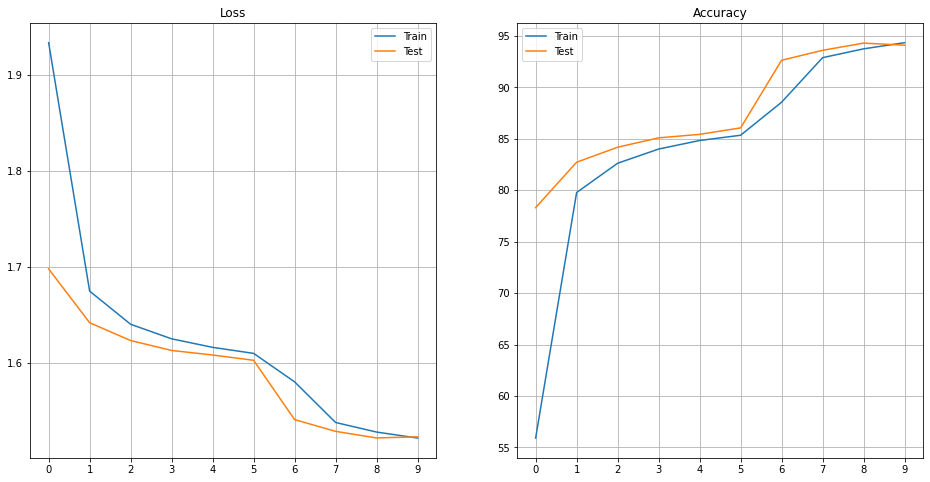

## 참고자료
<hr style="height:5px;border:none;color:#132e4f;background-color:#132e4f;"/>

- https://nbviewer.org/gist/minsuk-sung/bb9723993a2b0a79b07f71025ef54d98
- https://justkode.kr/deep-learning/pytorch-cnn
- https://jaeniworld.tistory.com/10
- https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
- https://clay-atlas.com/us/blog/2021/07/22/pytorch-en-index-error-dimension-out-of-range/
- https://wikidocs.net/63618
- https://sosomemo.tistory.com/59

<br>

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 모든 자료의 저작권은 성민석에 있으며 제작자의 동의없이 외부로의 무단 복제, 배포 및 전송을 절대로 불허합니다.

<b>Copyright ⓒ 2022. Minsuk Sung. All rights reserved.</b>
</span>

<br>